# 1 - Estimate when US Installs will reach EoL


Historical installations for U.S. Utility and non-Residential sector was calculated from:
1. 1995 through 1998: K. Bolcar and K. Ardani, “National Survey Report of PV Power Applications in the United States 2010,” IEA-PVPS, National Survey T1-19:2010, 2010. [Online]. Available: https://iea-pvps.org/national-survey-reports/.
2. L. Sherwood, “U.S. Solar Market Trends 2008,” Interstate Renewable Energy Council, Jul. 2009. Accessed: Sep. 15, 2021. [Online]. Available: https://irecusa.org/wp-content/uploads/2021/07/Solar-Market-Trends-2008.pdf
3. All Sherwood reports 2009-2014 for 1999 through 2009
4. Wood Mackenzie Data from 2010 forward.
5. “U.S. Solar Market Insight Report: 2012 Year in Review Full Report,” Greentech Media Inc. & SEIA, 2013 as a sanity check.

The calculations to select for only these 2 sectors and weight for c-Si can be found in Supporting Materials folder, files "Calculations-Installs-Subset-CommUtility.xlsx", "Installs-SubsetCommUtility.xlsx", and "Installs-SubsetCommUtility.csv".

These installations where then put into a module file. Installations after 2020 are set to 0, manufacturing efficiency is set to 100, and all circular EoL pathways are set to 0, sending all EoL material to the landfill. All lifetime and reliability, module efficiencies, and module degradation rates are taken from PV ICE baseline. The purpose of this calculation is to estimate when currently installed PV modules will come out of the field and need to be managed at EoL.

NOTE: this analysis has been updated for a 2022 release of an NREL decommissioning report. The update includes resolving a bug in how the Weibull function was applied to the cohorts, resolution of edge cases, and an update to the installation inputs, examining all 3 sectors of PV installs using Wood Mackenzie assumptions.

This analysis conducted for Taylor Curtis

In [2]:
import os
from pathlib import Path
import PV_ICE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


In [3]:
PV_ICE.__version__

'v0.2.0+227.gd6b927b.dirty'

### Add Scenarios and Materials


In [4]:
cwd=os.getcwd()
print(os.getcwd())

C:\Users\hmirletz\Documents\GitHub\PV_ICE\docs\tutorials


In [5]:
MATERIALS = ['glass','aluminium_frames','silver','silicon', 'copper', 'encapsulant', 'backsheet']
moduleFile = os.path.join(baselinesfolder, 'baseline_modules_mass_US_HistoryUtilCommOnly.csv')
newmodfilesPAth = os.path.join(supportMatfolder,'Calculations-Installs-Subset-CommUtility.xlsx')

In [6]:
newmoduleFile_raw = pd.read_excel(newmodfilesPAth, sheet_name='SectorInstalls', header=2)

In [7]:
newmoduleFile_raw.columns

Index(['year', 'Residential', 'Commercial', 'Utility',
       'All Sector All Tech Installs_[MWdc]', 'Unnamed: 5', 'Comm+Utility',
       'Total', 'Source', 'Residential MrktShr', 'Commercial MrktShr',
       'Source.1', 'Utility MrktShr', 'Source.2', 'Unnamed: 14',
       'Residential c-Si', 'Commercial c-Si', 'Utility c-Si',
       'All Sector c-Si Installs_[MWdc]', 'Unnamed: 19', 'Residential.1',
       'Commercial.1', 'Utility.1', 'Residential.2', 'Commercial.2',
       'Utility.2', 'Source.3'],
      dtype='object')

In [8]:
installs_allPV_df = newmoduleFile_raw.loc[:,newmoduleFile_raw.columns[0:5]] # all PV tech installs
installs_cSiPV_df = newmoduleFile_raw.loc[:,['Residential c-Si', 'Commercial c-Si', 'Utility c-Si',
                                          'All Sector c-Si Installs_[MWdc]']] # c-Si PV tech installs
installs_df = pd.concat([installs_allPV_df, installs_cSiPV_df], axis=1)

In [9]:
installs_df.columns

Index(['year', 'Residential', 'Commercial', 'Utility',
       'All Sector All Tech Installs_[MWdc]', 'Residential c-Si',
       'Commercial c-Si', 'Utility c-Si', 'All Sector c-Si Installs_[MWdc]'],
      dtype='object')

In [10]:
#load in a baseline and materials for modification
r1 = PV_ICE.Simulation(name='Simulation1', path=testfolder)
r1.createScenario(name='USHistory', massmodulefile=moduleFile) #points at the old module history installs file
for mat in range (0, len(MATERIALS)):
    MATERIALBASELINE = r'..\baselines\baseline_material_mass_'+MATERIALS[mat]+'.csv'
    r1.scenario['USHistory'].addMaterial(MATERIALS[mat], massmatfile=MATERIALBASELINE)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


### Modify the Simulation, create scenarios for each install/deployment history
Using the old/standard module baseline, we will modify/replace for each deployment schedule in the excel file. We will run the simulation for all tech and for just c-Si tech. For the all tech deployment, we will disregard the mass out since it it not representative of technologies (this will be improved in future). 

In [12]:
scennames = installs_df.columns[1:]
#['Residential', 'Commercial', 'Utility', 'All Sector All Tech Installs_[MWdc]',
#             'Residential c-Si', 'Commercial c-Si', 'Utility c-Si', 'All Sector c-Si Installs_[MWdc]']
scennames

Index(['Residential', 'Commercial', 'Utility',
       'All Sector All Tech Installs_[MWdc]', 'Residential c-Si',
       'Commercial c-Si', 'Utility c-Si', 'All Sector c-Si Installs_[MWdc]'],
      dtype='object')

In [13]:
for scens in scennames: #create all scenarios
    r1.createScenario(name=scens, massmodulefile=moduleFile) #create the scenario, name and mod file attach
    for mat in MATERIALS:
        materialfile = os.path.join(baselinesfolder, 'baseline_material_mass_'+str(mat)+'.csv')
        r1.scenario[scens].addMaterial(mat, massmatfile=materialfile) # add all materials listed in MATERIALS

In [14]:
#modify the scenario for deployments and degraation, T50 T90 values
for scens in scennames:
    r1.scenario[scens].dataIn_m.loc[0:len(installs_df['year']-1),'new_Installed_Capacity_[MW]'] = installs_df[scens]

# make sure 2022 and forward installs = 0, change degradation, and remove circularity and MFG wastes
enddeploydat = installs_df['year'].iloc[-1]
r1.modifyScenario(scenarios=None, stage='new_Installed_Capacity_[MW]', value=0, start_year=enddeploydat)
r1.modifyScenario(scenarios=None, stage='mod_degradation', value=0.75, start_year=2016) #based on Jordan et al 2022 doi/pdf/10.1002/pip.3566
r1.scenMod_noCircularity() # sets all module and material circular variables to 0, creating fully linear
r1.scenMod_PerfectManufacturing() #sets all manufacturing values to 100% efficiency/yield ignoring MFG waste

#check:
#r1.scenario['USHistory'].material['glass'].materialdata['mat_MFG_eff']

In [15]:
r1.scenario['Utility c-Si'].dataIn_m

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff,mod_EOL_collected_recycled,mod_Reuse
0,1995,12.000000,12.500000,16.0,21.0,0.55,10.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
1,1996,0.000000,12.700000,16.0,21.0,0.55,10.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
2,1997,0.000000,12.880000,19.0,23.0,0.55,15.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
3,1998,0.000000,13.060000,19.0,23.0,0.55,15.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
4,1999,0.000000,13.240000,19.0,23.0,0.55,15.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
5,2000,0.600000,13.420000,19.0,23.0,0.60,20.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
6,2001,3.700000,13.600000,19.0,23.0,0.60,20.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
7,2002,2.700000,13.722222,19.0,23.0,0.60,20.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
8,2003,3.600000,13.844444,19.0,23.0,0.60,20.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
9,2004,2.100000,13.966667,19.0,23.0,0.60,20.0,100.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0


### Run the Mass Flow Calculations on All Scenarios and Materials

In [16]:
r1.calculateMassFlow()


>>>> Calculating Material Flows <<<<

Working on Scenario:  USHistory
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Residential
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Commercial
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Workin

###  Use internal plotting functions to plot results

Pull out the keywords by printing the keys to the module data or the material data:

    print(r1.scenario.keys())
    
    print(r1.scenario['standard'].data.keys())
    
    print(r1.scenario['standard'].material['glass'].materialdata.keys())

In [17]:
#print(r1.scenario.keys())
print(r1.scenario['USHistory'].dataOut_m.keys())
#print(r1.scenario['USHistory'].material['glass'].materialdata.keys())

Index(['Area', 'Area_for_EOL_pathsG', 'Cumulative_Active_Area', 'EOL_BS_Year0',
       'EOL_BS_Year1', 'EOL_BS_Year10', 'EOL_BS_Year11', 'EOL_BS_Year12',
       'EOL_BS_Year13', 'EOL_BS_Year14',
       ...
       'Status_BAD_[W]', 'WeibullParams', 'Yearly_Sum_Area_disposed',
       'Yearly_Sum_Area_disposedby_Failure',
       'Yearly_Sum_Area_disposedby_ProjectLifetime',
       'Yearly_Sum_Power_disposed', 'Yearly_Sum_Power_disposedby_Failure',
       'Yearly_Sum_Power_disposedby_ProjectLifetime', 'irradiance_stc',
       'landfilled_noncollected'],
      dtype='object', length=209)


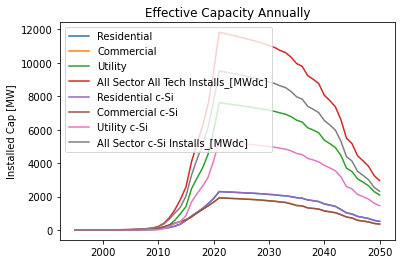

In [23]:
for scen in scennames:
    plt.plot(r1.scenario[scen].dataIn_m['year'], 
             r1.scenario[scen].dataOut_m['Installed_Capacity_[W]']/10e6, label=scen)

plt.title('Effective Capacity Annually')
plt.ylabel('Installed Cap [MW]')
plt.legend()

In [24]:
usyearlyr1, uscumr1 = r1.aggregateResults()
usyearlyr1.to_csv('historicalUS-yearly.csv')
uscumr1.to_csv('historicalUS-cumulative.csv')

## Pretty Plots

In [32]:
alltechscens = installs_df.columns[1:5]
cSitechscens = installs_cSiPV_df.columns

In [ ]:
#all techs plot
plt.plot([],[],color='blue', label='Residential')
plt.plot([],[],color='orange', label='Commercial')
plt.plot([],[],color='brown', label='Utility')


plt.stackplot(df_mfg_energies.index, 
              df_mfg_energies['E_reduceSilicatoMGSi'], 
              df_mfg_energies['ErefineSiemens kWh/kg'],
              df_mfg_energies['E_Ingot_kWhpkg'], 
              df_mfg_energies['E_Wafering_kWhpkg'], 
              df_mfg_energies['E_cellProcess_kWhpkg'],
             colors = ['blue','orange','brown','green','red'])
plt.title('Electricity: Silicon Manufacturing')
plt.ylabel('Electricity Demand [kWh/kg]')
plt.xlim(1995,2022)
plt.legend()
plt.show()

NameError: name 'df_mfg_energies' is not defined

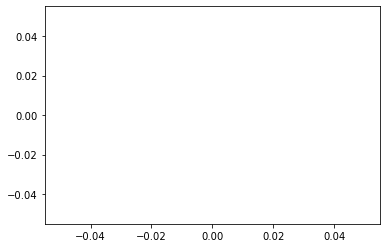

In [34]:
#c-Si  plot
plt.plot([],[],color='blue', label='Reduce Si')
plt.plot([],[],color='orange', label='Refine Si')
plt.plot([],[],color='brown', label='Ingot')
plt.plot([],[],color='green', label='Wafer')
plt.plot([],[],color='red', label='Cell')

plt.stackplot(df_mfg_energies.index, df_mfg_energies['E_reduceSilicatoMGSi'], 
              df_mfg_energies['ErefineSiemens kWh/kg'],
              df_mfg_energies['E_Ingot_kWhpkg'], 
              df_mfg_energies['E_Wafering_kWhpkg'], 
              df_mfg_energies['E_cellProcess_kWhpkg'],
             colors = ['blue','orange','brown','green','red'])
plt.title('Electricity: Silicon Manufacturing')
plt.ylabel('Electricity Demand [kWh/kg]')
plt.xlim(1995,2022)
plt.legend()
plt.show()

In [ ]:
#create a yearly Module Waste Mass
USyearly=pd.DataFrame()
keyword = 'mat_Total_Landfilled'
for mat in range (0, len(MATERIALS)):
    material = MATERIALS[mat]
    foo = r1.scenario['USHistory'].material[material].matdataOut_m[keyword].copy()
    foo = foo.to_frame(name=material)
    USyearly["Waste_"+material] = foo[material]

#sum the columns for module mass
USyearly['Waste_Module'] = USyearly.sum(axis=1)

USyearly.head(10)

In [ ]:
#add index
USyearly.index = r1.scenario['USHistory'].dataIn_m['year']

In [ ]:
#Convert to million metric tonnes
USyearly_mil_tonnes=USyearly/1000000000000

In [ ]:
#Adding new installed capacity for decomissioning calc
USyearly_mil_tonnes['new_Installed_Capacity_[MW]'] = r1.scenario['USHistory'].dataIn_m['new_Installed_Capacity_[MW]'].values

In [ ]:
UScum = USyearly_mil_tonnes.copy()
UScum = UScum.cumsum()

UScum.head()

In [ ]:
bottoms = pd.DataFrame(UScum.loc[2050])
bottoms

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
a0.plot(USyearly_mil_tonnes.index, USyearly_mil_tonnes['Waste_Module'], 'k.', linewidth=5, label='EoL Module Mass')
a0.plot(USyearly_mil_tonnes.index, USyearly_mil_tonnes['Waste_glass'], 'k', linewidth=5, label='EoL Glass Mass')
a0.fill_between(USyearly_mil_tonnes.index, USyearly_mil_tonnes['Waste_glass'], USyearly_mil_tonnes['Waste_Module'],
                color='k', alpha=0.3, interpolate=True)

a0.legend()
a0.set_title('Yearly EoL Material Mass')
a0.set_ylabel('Mass [Million Tonnes]')
a0.set_xlim([1995, 2050])
a0.set_xlabel('Years')

########################    
# SUBPLOT 2
########################
## Plot BARS Stuff
ind=np.arange(1)
width=0.35 # width of the bars.

bottoms = pd.DataFrame(UScum.loc[2050])

p0 = a1.bar(ind, UScum.loc[2050]['Waste_glass'], width, color='c')
p1 = a1.bar(ind, UScum.loc[2050]['Waste_aluminium_frames'], width, bottom=bottoms.iloc[0])
p2 = a1.bar(ind, UScum.loc[2050]['Waste_silicon'], width, bottom=(bottoms.iloc[1]+bottoms.iloc[0]))
p3 = a1.bar(ind, UScum.loc[2050]['Waste_copper'], width, bottom=(bottoms.iloc[2]+bottoms.iloc[1]+bottoms.iloc[0]))
p4 = a1.bar(ind, UScum.loc[2050]['Waste_silver'], width, bottom=(bottoms.iloc[3]+bottoms.iloc[2]+bottoms.iloc[1]+bottoms.iloc[0]))
p5 = a1.bar(ind, UScum.loc[2050]['Waste_encapsulant'], width, bottom=(bottoms.iloc[4]+bottoms.iloc[3]+bottoms.iloc[2]+bottoms.iloc[1]+bottoms.iloc[0]))
p6 = a1.bar(ind, UScum.loc[2050]['Waste_backsheet'], width, bottom=(bottoms.iloc[5]+bottoms.iloc[4]+bottoms.iloc[3]+bottoms.iloc[2]+bottoms.iloc[1]+bottoms.iloc[0]))

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('EoL PV Material [Million Tonnes]')
a1.set_xlabel('Cumulative in 2050')
a1.set_xticks(ind)
a1.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0], p6[0] ), ('Glass', 'Aluminium frames', 'Silicon','Copper','Silver', 'Encapsulant', 'Backsheet'))

# Plot and Table of decommissioned in MW
decommissioned yearly = cumulative new installs - yearly active capacity

the decommissioned yearly column is actually cumulative, so do reverse cum on it.

Create a table output of installs, active generating capacity annually decommissioned, cumulatively decomissioned, and cumulative decomissioned module mass.

In [ ]:
usyearlyr1.head()

In [ ]:
tidy_results = usyearlyr1.iloc[:,32:]
tidy_results.columns = ('new_Installed_Capacity_[MW]', 'Active_Capacity_[MW]','Cumulative_Decomissioned_Capacity_[MW]')

In [ ]:
#tidy_results['Annual_Decommissioned_Capacity_[MW]'] = 
tidy_results['Annual_Decomissioned_Capacity_[MW]'] = tidy_results['Cumulative_Decomissioned_Capacity_[MW]']-tidy_results['Cumulative_Decomissioned_Capacity_[MW]'].shift(1).fillna(0)
tidy_results['Cumulative_Module_Mass_Decommissioned_[million tonnes]'] = usyearlyr1.filter(like='WasteAll_Module')/1e6
tidy_results

In [ ]:
tidy_results.to_csv(path_or_buf=r'..\baselines\SupportingMaterial\US_Historical_PV_Decomissioning.csv')